## Loading other modules -> used to create train module

In [1]:
from nb.models import mininest_ba, mininest_bn, mininet, xmininet, xsemininet
from nb.databunch import DataBunch
from nb.learner import Learner, model_config

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm as tq
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd

In [3]:
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingLR

### Loading Data

In [4]:
from pathlib import Path

In [86]:
def load_data(root=None, remove=None, headers=None):
    data = Path('./OmegaDev/Model_Z/raw_data/GBP_USD_H1_2015-01-01_2020-01-01.csv') if root is None else Path(root)
    headers = ['date', 'complete', 'open', 'high', 'low', 'close', 'volume'] if headers is None else headers
    df = pd.read_csv(data, header=None, names=headers)
    return df

# loading our dataframe
df = load_data()

# TAs to remove -> memory constraint
ta_to_remove = ['others_dr', 'others_dlr', 'others_cr', 'momentum_rsi', 'momentum_tsi', 'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama', 'momentum_roc', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'trend_aroon_down', 'trend_aroon_ind', 'trend_aroon_up']

ta_to_remove = ['volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi',
       'momentum_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_rsi', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_kama', 'momentum_roc', 'others_dr',
       'others_dlr', 'others_cr']

# loading data object
data = (DataBunch(df=df,
                  pct=0.1,
                  window=24,
                  lbl_window=12,
                  gaxf_type='gasf',
                  ta_to_remove=ta_to_remove)
       .bunch(bs=16, shuffle=True))

C:\Users\dmber\Anaconda3\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\Users\dmber\Anaconda3\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])
C:\Users\dmber\Anaconda3\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\Users\dmber\Anaconda3\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


## Trainer

In [87]:
class DelayerScheduler(_LRScheduler):
    """
    CREDIT: https://github.com/pabloppp/pytorch-tools
    Start with a flat lr schedule until it reaches N epochs then applies a scheduler
    """
    def __init__(self, optimizer, delay_epochs, after_scheduler):
        self.delay_epochs = delay_epochs
        self.after_scheduler = after_scheduler
        self.finished = False
        super().__init__(optimizer)
        
    def get_lr(self):
        if self.last_epoch >= self.delay_epochs:
            if not self.finished:
                self.after_scheduler.base_lrs = self.base_lrs
                self.finished = True
            return self.after_scheduler.get_last_lr()
        
        return self.base_lrs
    
    def step(self, epoch=None):
        if self.finished:
            if epoch is None: 
                self.after_scheduler.step(None)
            else:
                self.after_scheduler.step(epoch - self.delay_epochs)
        else:
            return super(DelayerScheduler, self).step(epoch)

In [88]:
def FlatCosAnnealScheduler(optimizer, delay_epochs, cosine_annealing_epochs):
    base_scheduler = CosineAnnealingLR(optimizer, cosine_annealing_epochs)
    return DelayerScheduler(optimizer, delay_epochs, base_scheduler)

In [89]:
def delayer(epochs, pct_start=0.8): return int(epochs * pct_start)

In [90]:
class Evaluate:
    """
    Keeping track of stats when training a model. Evolution will be all training stats for the entire training while summary is epoch summary per epoch
    """
    def __init__(self):
        self.evolution = {'train_loss':[], 'train_acc':[], 'valid_loss':[], 'valid_acc':[]}
        self.summary = {'train_loss_summary':[], 'train_acc_summary':[], 'valid_loss_summary':[], 'valid_acc_summary':[]}
        self.best_stats = {}
        
    def update_summary(self, train_loss, train_acc, valid_loss, valid_acc):
        """Call after each epoch"""
        self.summary['train_loss_summary'].append(train_loss)
        self.summary['train_acc_summary'].append(train_acc)
        self.summary['valid_loss_summary'].append(valid_loss)
        self.summary['valid_acc_summary'].append(valid_acc)
    
    def update_evolution(self, ds_type, loss, acc):
        """Call after each batch"""
        if ds_type=='train':
            self.evolution['train_loss'].append(loss)
            self.evolution['train_acc'].append(acc)
        elif ds_type=='valid':
            self.evolution['valid_loss'].append(loss)
            self.evolution['valid_acc'].append(acc)
        else: return
        
    def update_best_stats(self, iteration, train_loss, train_acc, valid_loss, valid_acc):
        self.best_stats['iteration'] = iteration
        self.best_stats['train_loss'] = train_loss
        self.best_stats['train_acc'] = train_acc
        self.best_stats['valid_losss'] = valid_loss
        self.best_stats['valid_acc'] = valid_acc
        
    def report(self):
        tq.write(f"""Train loss: {self.summary['train_loss_summary'][-1]:0f}, Train acc: {self.summary['train_acc_summary'][-1]:0f}, Valid loss: {self.summary['valid_loss_summary'][-1]:0f}, Valid acc: {self.summary['valid_acc_summary'][-1]:0f}""")
        
    def summarize(self): self.summary = pd.DataFrame(self.summary)
    
    def report_best(self):
        print(f"""
        Best Model Stats:
        ---------------------------------
        Iteration  : {self.best_stats['iteration']}
        Train Loss : {self.best_stats['train_loss']}
        Train Acc  : {self.best_stats['train_acc']}
        Valid Loss : {self.best_stats['valid_loss']}
        Valid Acc  : {self.best_stats['valid_acc']}
        """)
        
    def plot_summary(self):
        if isinstance(self.summary, pd.DataFrame): self.summary.plot()
            
    def plot_evolution(self):
        fig, axs = plt.subplots(2,2, figsize=(15,10))
        
        axs[0,0].plot(self.evolution['train_acc'])
        axs[0,0].set_xlabel('Iterations')
        axs[0,0].set_ylabel('Accuracy')
        axs[0,0].set_title('Train Accuracy')
        
        axs[0,1].plot(self.evolution['valid_acc'])
        axs[0,1].set_xlabel('Iterations')
        axs[0,1].set_ylabel('Accuracy')
        axs[0,1].set_title('Valid Accuracy')
        
        axs[1,0].plot(self.evolution['train_loss'])
        axs[1,0].set_xlabel('Iterations')
        axs[1,0].set_ylabel('Loss')
        axs[1,0].set_title('Train Loss')
        
        axs[1,1].plot(self.evolution['valid_loss'])
        axs[1,1].set_xlabel('Iterations')
        axs[1,1].set_ylabel('Loss')
        axs[1,1].set_title('Valid Loss')
        
        plt.show()

In [91]:
def metrics_batch(output, target, metric_fn=None):
    if metric_fn: return metric_fn(output, target)

In [92]:
def loss_batch(loss_fn, output, target, metric_fn=None, opt_fn=None, scheduler=None):
    """
    Calculate loss and metric for batch
    """
    loss = loss_fn(output, target)
    metric = metrics_batch(output, target, metric_fn)
    
    if opt_fn:
        opt_fn.zero_grad()
        loss.backward()
        opt_fn.step()
        if scheduler: scheduler.step()
            
    return loss.data.cpu().item(), metric

In [93]:
def loss_epoch(model, dataloader, ds_type, evaluator, loss_fn, metric_fn=None, opt_fn=None, scheduler=None, device=None, inner_bar=None, inner_loop=None):
    """
    Calculates loss per batch
    """
    running_loss, running_metric = 0,0
    n = len(dataloader.dataset)
    device = torch.device('cpu') if device is None else device
    
    for i,(xb,yb) in enumerate(dataloader):
        inner_bar.update(1)
        nb = yb.size(0)
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        
        loss_b, metric_b = loss_batch(loss_fn, output, yb, metric_fn, opt_fn, scheduler)
        running_loss+=loss_b
        running_metric+=metric_b
        evaluator.update_evolution(ds_type, running_loss/(nb*(i+1)), running_metric/(nb*(i+1)))
        
    metric_e = running_metric/float(n)
    loss_e = running_loss/float(n)
    return metric_e, loss_e

In [94]:
def fit(learn, epochs=10, device=None, keep_best_state=True, **kwargs):
    """
    train model with one cycle policy
    """
    evaluator = Evaluate()
    
    # update opt
    opt_fn = learn.opt_fn
    
    # base
    loss_fn = learn.loss_fn
    train_dl = learn.data.train_dl
    valid_dl = learn.data.valid_dl
    metric_fn = learn.metric_fn
    device = learn.device if device is None else torch.device(device)
    model = learn.model.to(device)
    
    # display settings
    outter_bar = tqdm.tqdm(range(epochs))
    outter_loop = range(epochs)
    train_n = len(train_dl)
    train_inner_bar = tqdm.tqdm(range(train_n), leave=False)
    train_inner_loop = range(train_n)
    valid_n = len(valid_dl)
    valid_inner_bar = tqdm.tqdm(range(valid_n), leave=False)
    valid_inner_loop = range(valid_n)
    
    # best model weights
    if keep_best_state:
        best_model_wts = deepcopy(model.state_dict())
        best_loss = float('inf')
        
    # Training
    for epoch in outter_loop:
        train_inner_bar.reset()
        valid_inner_bar.reset()
        
        # train
        model.train()
        train_metric, train_loss = loss_epoch(model, train_dl, 'train', evaluator, loss_fn, metric_fn, opt_fn, None, device, train_inner_bar, train_inner_loop)
        
        # eval
        model.eval()
        with torch.no_grad():
            valid_metric, valid_loss = loss_epoch(model, valid_dl, 'valid', evaluator, loss_fn, metric_fn, device=device, inner_bar=valid_inner_bar, inner_loop=valid_inner_loop)
            
        # update evaluator
        evaluator.update_summary(train_loss, train_metric, valid_loss, valid_metric)
        
        # keeping best
        if keep_best_state:
            if valid_loss<best_loss:
                best_loss = valid_loss
                best_model_wts = deepcopy(model.state_dict())
                evaluator.update_best_stats(epoch+1, train_loss, train_metric, valid_loss, valid_metric)
                
        # report
        outter_bar.update(1)
        evaluator.report()
        
    # summurize training
    evaluator.summarize()
    learn.evaluator = evaluator
    
    # keep best weights
    if keep_best_state: learn.model.load_state_dict(best_model_wts)

In [95]:
def fit_one_cycle(learn, epochs=10, pct_start=0.8, div_factor=10., moms=(0.85, 0.95), device=None, keep_best_state=True, **kwargs):
    """
    train model with one cycle policy
    """
    # setting training params
    evaluator = Evaluate()
    
    # scheduler params
    steps_per_epoch = len(learn.data.train_dl)
    b1, b2 = moms
    opt_fn = learn.opt_fn
    scheduler = lr_scheduler.OneCycleLR(opt_fn, max_lr=max_lr, steps_per_epoch=steps_per_epoch, epochs=epochs, pct_start=pct_start, div_factor=div_factor, base_momentum=b1, max_momentum=b2)
    
    # base
    loss_fn = learn.loss_fn
    train_dl = learn.data.train_dl
    valid_dl = learn.data.valid_dl
    metric_fn = learn.metric_fn
    device = learn.device if device is None else torch.device(device)
    model = learn.model.to(device)
    
    # display settings
    outter_bar = tqdm.tqdm(range(epochs))
    outter_loop = range(epochs)
    train_n = len(train_dl)
    train_inner_bar = tqdm.tqdm(range(train_n), leave=False)
    train_inner_loop = range(train_n)
    valid_n = len(valid_dl)
    valid_inner_bar = tqdm.tqdm(range(valid_n), leave=False)
    valid_inner_loop = range(valid_n)
    
    # best model weights
    if keep_best_state:
        best_model_wts = deepcopy(model.state_dict())
        best_loss = float('inf')
        
    # Training
    for epoch in outter_loop:
        train_inner_bar.reset()
        valid_inner_bar.reset()
        
        # train
        model.train()
        train_metric, train_loss = loss_epoch(model, train_dl, 'train', evaluator, loss_fn, metric_fn, opt_fn, scheduler, device, train_inner_bar, train_inner_loop)
        
        # eval
        model.eval()
        with torch.no_grad():
            valid_metric, valid_loss = loss_epoch(model, valid_dl, 'valid', evaluator, loss_fn, metric_fn, device=device, inner_bar=valid_inner_bar, inner_loop=valid_inner_loop)
            
        # update evaluator
        evaluator.update_summary(train_loss, train_metric, valid_loss, valid_metric)
        
        # keeping best
        if keep_best_state:
            if valid_loss<best_loss:
                best_loss = valid_loss
                best_model_wts = deepcopy(model.state_dict())
                evaluator.update_best_stats(epoch+1, train_loss, train_metric, valid_loss, valid_metric)
                
        # report
        outter_bar.update(1)
        evaluator.report()
        
    # summurize training
    evaluator.summarize()
    learn.evaluator = evaluator
    
    # keep best weights
    if keep_best_state: learn.model.load_state_dict(best_model_wts)

In [96]:
def fit_flat_anneal(learn, epochs=10, pct_start=0.8, div_factor=10., moms=(0.85, 0.95), device=None, keep_best_state=True, **kwargs):
    """
    train model with one cycle policy
    """
    evaluator = Evaluate()
    
    # scheduler params
    steps_per_epoch = len(learn.data.train_dl)
    b1, b2 = moms
    delay_epochs = delayer(epochs, pct_start)
    opt_fn = learn.opt_fn
    base_scheduler = CosineAnnealingLR(opt_fn, delay_epochs)
    delayed_scheduler = DelayerScheduler(opt_fn, epochs-delay_epochs, base_scheduler)
    
    # base
    loss_fn = learn.loss_fn
    train_dl = learn.data.train_dl
    valid_dl = learn.data.valid_dl
    metric_fn = learn.metric_fn
    device = learn.device if device is None else torch.device(device)
    model = learn.model.to(device)
    
    # display settings
    outter_bar = tqdm.tqdm(range(epochs))
    outter_loop = range(epochs)
    train_n = len(train_dl)
    train_inner_bar = tqdm.tqdm(range(train_n), leave=False)
    train_inner_loop = range(train_n)
    valid_n = len(valid_dl)
    valid_inner_bar = tqdm.tqdm(range(valid_n), leave=False)
    valid_inner_loop = range(valid_n)
    
    # best model weights
    if keep_best_state:
        best_model_wts = deepcopy(model.state_dict())
        best_loss = float('inf')
        
    # Training
    for epoch in outter_loop:
        train_inner_bar.reset()
        valid_inner_bar.reset()
        
        # train
        model.train()
        train_metric, train_loss = loss_epoch(model, train_dl, 'train', evaluator, loss_fn, metric_fn, opt_fn, None, device, train_inner_bar, train_inner_loop)
        
        # eval
        model.eval()
        with torch.no_grad():
            valid_metric, valid_loss = loss_epoch(model, valid_dl, 'valid', evaluator, loss_fn, metric_fn, device=device, inner_bar=valid_inner_bar, inner_loop=valid_inner_loop)
            
        # update evaluator
        evaluator.update_summary(train_loss, train_metric, valid_loss, valid_metric)
        
        # keeping best
        if keep_best_state:
            if valid_loss<best_loss:
                best_loss = valid_loss
                best_model_wts = deepcopy(model.state_dict())
                evaluator.update_best_stats(epoch+1, train_loss, train_metric, valid_loss, valid_metric)
                
        # update scheduler
        delayed_scheduler.step()
        
        # report
        outter_bar.update(1)
        evaluator.report()
        
    # summurize training
    evaluator.summarize()
    learn.evaluator = evaluator
    
    # keep best weights
    if keep_best_state: learn.model.load_state_dict(best_model_wts)

In [97]:
Learner.fit = fit
Learner.fit_one_cycle = fit_one_cycle
Learner.fit_flat_anneal = fit_flat_anneal

## Testing

In [98]:
from nb.optimizers import Ranger
import torch.optim as optim

In [109]:
alpha = 0.98
mom = 0.94
wd = 0.
lr = 1e-4
eps = 1e-6

torch.manual_seed(5)
torch.cuda.manual_seed(5)

in_c, num_classes = model_config(data)
model = mininet(in_c, num_classes=num_classes)

# opt_fn = Ranger(params=model.parameters(), betas=(mom, alpha), eps=eps, weight_decay=wd, lr=lr)
opt_fn = optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)

learn = Learner(
    data,
    model,
    opt_fn=opt_fn,
    lr=lr,
    wd=wd
)

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


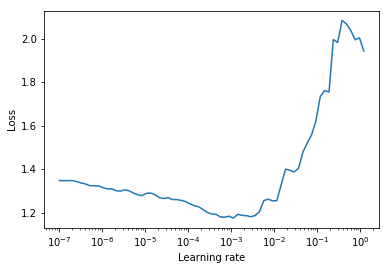

In [108]:
learn.lr_finder()

In [ ]:
learn.fit(20, keep_best_state=False)

Train loss: 0.064819, Train acc: 0.484888, Valid loss: 0.065668, Valid acc: 0.467381
Train loss: 0.061711, Train acc: 0.520377, Valid loss: 0.065648, Valid acc: 0.456670
Train loss: 0.059775, Train acc: 0.540503, Valid loss: 0.067056, Valid acc: 0.491723
Train loss: 0.057600, Train acc: 0.563637, Valid loss: 0.066624, Valid acc: 0.498539
Train loss: 0.054296, Train acc: 0.598517, Valid loss: 0.071319, Valid acc: 0.467056
Train loss: 0.049909, Train acc: 0.641813, Valid loss: 0.074306, Valid acc: 0.455047
Train loss: 0.044374, Train acc: 0.688619, Valid loss: 0.083962, Valid acc: 0.449529
Train loss: 0.038264, Train acc: 0.742480, Valid loss: 0.088243, Valid acc: 0.444661
Train loss: 0.032785, Train acc: 0.783305, Valid loss: 0.097349, Valid acc: 0.424862


In [33]:
correct = 0
for xb,yb in data.train_dl:
    xb = xb.to(device)
    out = learn.model(xb)
    out = torch.argmax(out.data.cpu(),1)
    corr = (out==yb).sum().item()
    correct+=corr
    
correct/len(data.train_dl.dataset)

0.5379109135936493

In [34]:
learn.evaluator.summary

,train_loss_summary,train_acc_summary,valid_loss_summary,valid_acc_summary
0,0.089902,0.125081,0.087984,0.126309
1,0.085045,0.154968,0.082516,0.180628
2,0.080641,0.200156,0.079865,0.217932
3,0.076694,0.259049,0.073306,0.320681
4,0.072596,0.325610,0.070202,0.379581
5,0.068887,0.387963,0.067978,0.411649
6,0.065424,0.436204,0.064548,0.462696
7,0.062090,0.478000,0.062491,0.475785
8,0.059236,0.503477,0.058739,0.507199
9,0.056781,0.516979,0.056666,0.524215


# TODO:
0. What causes overfitting? Read into this first. Can a simplier model work?
1. Play with Thresholds -> look more into the labeling scheme. What happens when we change the thresholds? What are the counts for both the training_dl and valid_dl? Try different extremes and see if there is a difference
2. Play with another labeling scheme. Try stationary close again, does this perform differently? 
3. Attempt more data once more 
4. Build capsule network -> does this perform different?
5. Include an RNN as the decoder -> head -> classification

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


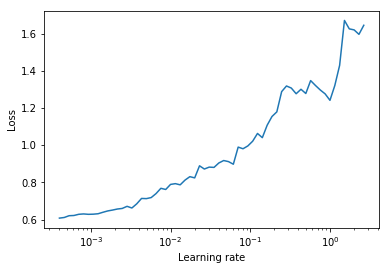

set state called


In [24]:
learn.lr_finder()